# Make some density shells

In [3]:
import numpy as np
from bnt_smooth import LognormalWeakLensingSim  # your class file

# --- Define a parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 2.5, 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 1234
l_max = 256
lognormal_shift = 1.0
zmax = 3.0
nslices = 50

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    zmax=zmax,
    nslices=nslices
)

# --- Generate lognormal matter fields from scratch ---
maps = sim.generate_matter_fields_from_scratch()

# --- Print summary ---
print(f"Generated {len(maps)} lognormal HEALPix maps.")
print(f"Each map has {maps[0].size} pixels (nside = {sim.nside})")

/Users/taylor.4264/test/BNTSmooth/bnt_smooth.py:126: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  delta_g = hp.synfast(full_cl, nside=nside, verbose=False)


Generated 50 lognormal HEALPix maps.
Each map has 786432 pixels (nside = 256)


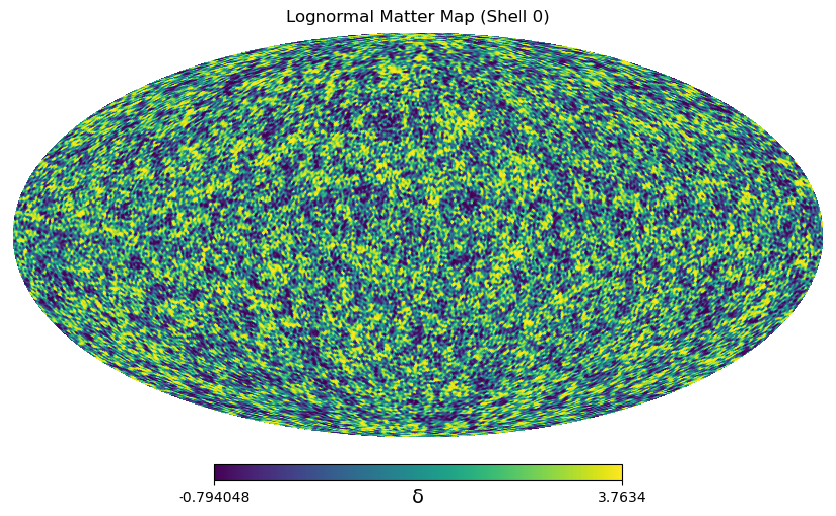

In [4]:
import healpy as hp
import matplotlib.pyplot as plt

# --- Plot the first map (shell 0) ---
hp.mollview(maps[4], title="Lognormal Matter Map (Shell 0)", unit="δ", norm='hist')
plt.show()


# Use these to compute kappa maps

Generated 50 lognormal matter maps.
Computed 3 κ-maps (one per tomographic bin).


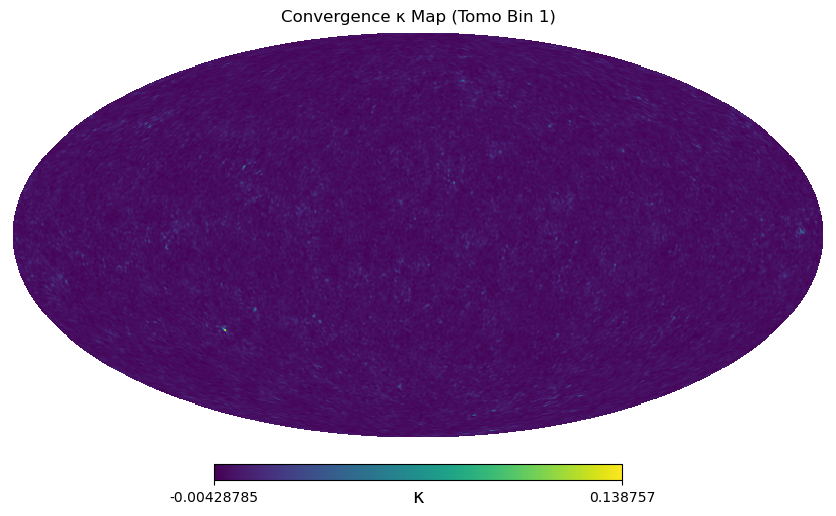

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from bnt_smooth import LognormalWeakLensingSim

# --- Define parent n(z) and tomographic binning ---
def parent_nz(z):
    return z**2 * np.exp(-(z / 0.5)**1.5)

def make_equal_ngal_bins(nz_func, z, nbins):
    from scipy.interpolate import interp1d
    nz = nz_func(z)
    nz /= np.trapezoid(nz, z)
    cdf = np.cumsum(nz)
    cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate([[0], cdf, [1]]),
                       np.concatenate([[z[0]], z, [z[-1]]]))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i+1])
        bins.append((z[mask], nz[mask]))
    return bins, edges

# --- Simulation settings ---
z = np.linspace(0.01, 3., 500)
nz_list, _ = make_equal_ngal_bins(parent_nz, z, nbins=3)
n_eff_list = [30.0] * 3
sigma_eps_list = [0.26] * 3
baryon_feedback = 3.13
sigma8 = 0.8
seed = 42
l_max = 256
lognormal_shift = 1.0
zmax = 3.0
nslices = 50

# --- Initialize simulation ---
sim = LognormalWeakLensingSim(
    nz_list=nz_list,
    n_eff_list=n_eff_list,
    sigma_eps_list=sigma_eps_list,
    baryon_feedback=baryon_feedback,
    sigma8=sigma8,
    lognormal_shift=lognormal_shift,
    seed=seed,
    l_max=l_max,
    zmax=zmax,
    nslices=nslices
)

# --- Step 1: Generate lognormal matter fields ---
matter_maps = sim.generate_matter_fields_from_scratch()
print(f"Generated {len(matter_maps)} lognormal matter maps.")

# --- Step 2: Compute kappa maps for each tomographic bin ---
kappa_maps = sim.compute_kappa_maps(matter_maps)
print(f"Computed {len(kappa_maps)} κ-maps (one per tomographic bin).")

# --- Step 3: Plot the first κ-map ---
hp.mollview(kappa_maps[0], title="Convergence κ Map (Tomo Bin 1)", unit="κ")
plt.show()

# Let's see what happens to the histogram for different values of the lognormal shift parameter

Computing κ map with lognormal_shift = 0.7
Computing κ map with lognormal_shift = 1.0
Computing κ map with lognormal_shift = 1.3
0.0008756313502590639
0.0012317090760514116
0.0016348462173618797


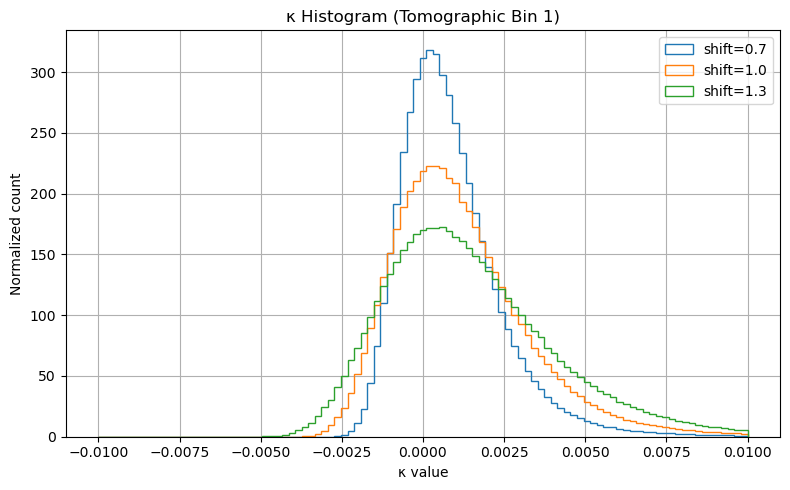

In [11]:
import matplotlib.pyplot as plt

# --- Define shift values to compare ---
shifts = [0.7, 1.0, 1.3, ]
hist_data = []

for shift in shifts:
    print(f"Computing κ map with lognormal_shift = {shift}")
    
    # Set shift and regenerate matter maps
    sim.lognormal_shift = shift
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(-0.01, 0.01, 100)  # Adjust range as needed

for i, kappa in enumerate(hist_data):
    print (np.mean(kappa))
    plt.hist(kappa, bins=bins, histtype='step', label=f'shift={shifts[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1)")
plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# visualise what happens for different values of the baryonic feedback parameter

Computing κ map with baryon_feedback = 1.0
Computing κ map with baryon_feedback = 3.13
Computing κ map with baryon_feedback = 100.0
Mean κ for feedback=1.0: 1.6068e-03
Mean κ for feedback=3.13: 1.6332e-03
Mean κ for feedback=100.0: 1.6159e-03


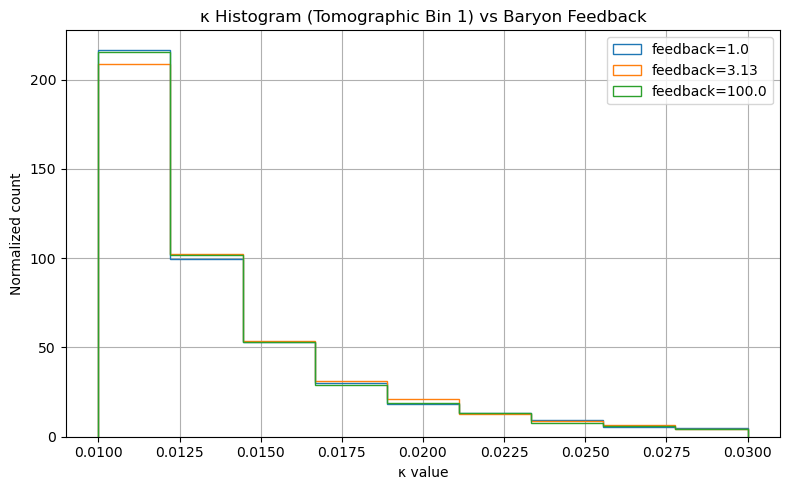

In [18]:
import matplotlib.pyplot as plt

# --- Define baryonic feedback values to compare ---
feedback_values = [1.0, 3.13, 100.]
hist_data = []

for feedback in feedback_values:
    print(f"Computing κ map with baryon_feedback = {feedback}")
    
    # Set feedback parameter and regenerate matter maps
    sim.baryon_feedback = feedback
    matter_maps = sim.generate_matter_fields_from_scratch()
    
    # Compute kappa maps
    kappa_maps = sim.compute_kappa_maps(matter_maps)
    
    # Take the first tomographic bin
    kappa_bin_0 = kappa_maps[0]
    hist_data.append(kappa_bin_0)

# --- Plot histograms ---
plt.figure(figsize=(8, 5))
bins = np.linspace(0.01, 0.03, 10)  # Adjust as needed

for i, kappa in enumerate(hist_data):
    print(f"Mean κ for feedback={feedback_values[i]}: {np.mean(kappa):.4e}")
    plt.hist(kappa, bins=bins, histtype='step', label=f'feedback={feedback_values[i]}', density=True)

plt.xlabel("κ value")
plt.ylabel("Normalized count")
plt.title("κ Histogram (Tomographic Bin 1) vs Baryon Feedback")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()